# Reconstruction Sandbox
This notebook is a test-bed for regularization and reconstruction methods

In [ ]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Load motiondeblur module and Dataset class
import libwallerlab.projects.motiondeblur as md
from libwallerlab.utilities.io import Dataset, isDataset

# Platform imports
import os, glob
from os.path import expanduser

# Debugging imports
import llops as yp
import matplotlib.pyplot as plt
import numpy as np

yp.config.setDefaultBackend('numpy')
yp.config.setDefaultDatatype('float32')

## Define Output Path

In [2]:
output_path = os.path.expanduser('~/datasets/motiondeblur/beads_output')
if not os.path.exists(output_path):
    os.mkdir(output_path)

## Load Data

In [3]:
dataset_full_path = os.path.expanduser('/Users/zfphil/Dropbox/01-24-19-MotionDeblur/beads_line_coded_raster_100_motion deblur_2019_01_24_14_24_03/')

# Create dataset object (loads metadata)
dataset = Dataset(dataset_full_path, use_median_filter=False, subtract_mean_dark_current=True)#'res' not in dataset_label)

Loading 1 frames...


## Perform Registration and Normalization

In [ ]:
force = True

# Perform registration
dataset.motiondeblur.register(force=force)

# Perform normalization
dataset.motiondeblur.normalize(force=force)

# Perform kernel shape 
dataset.metadata.calibration['blur_vector'] = {'scale': {'axis': 1, 'factor': 1}}

## Solve For Single Segment

In [4]:
from libwallerlab.projects.motiondeblur import bluranalysis as analysis

# dataset.motiondeblur.position_segment_indicies = [0]
dataset.frame_mask = [10,11,12,13,14]

# Create recon object
recon = md.recon.Reconstruction(dataset, alpha_blend_distance=1000, normalize=False, estimate_background_poly=True)
analysis.calcDnfFromKernel(recon.blur_kernel_list[0])

Loading 5 frames...


1258.852716946253

<IPython.core.display.Javascript object>


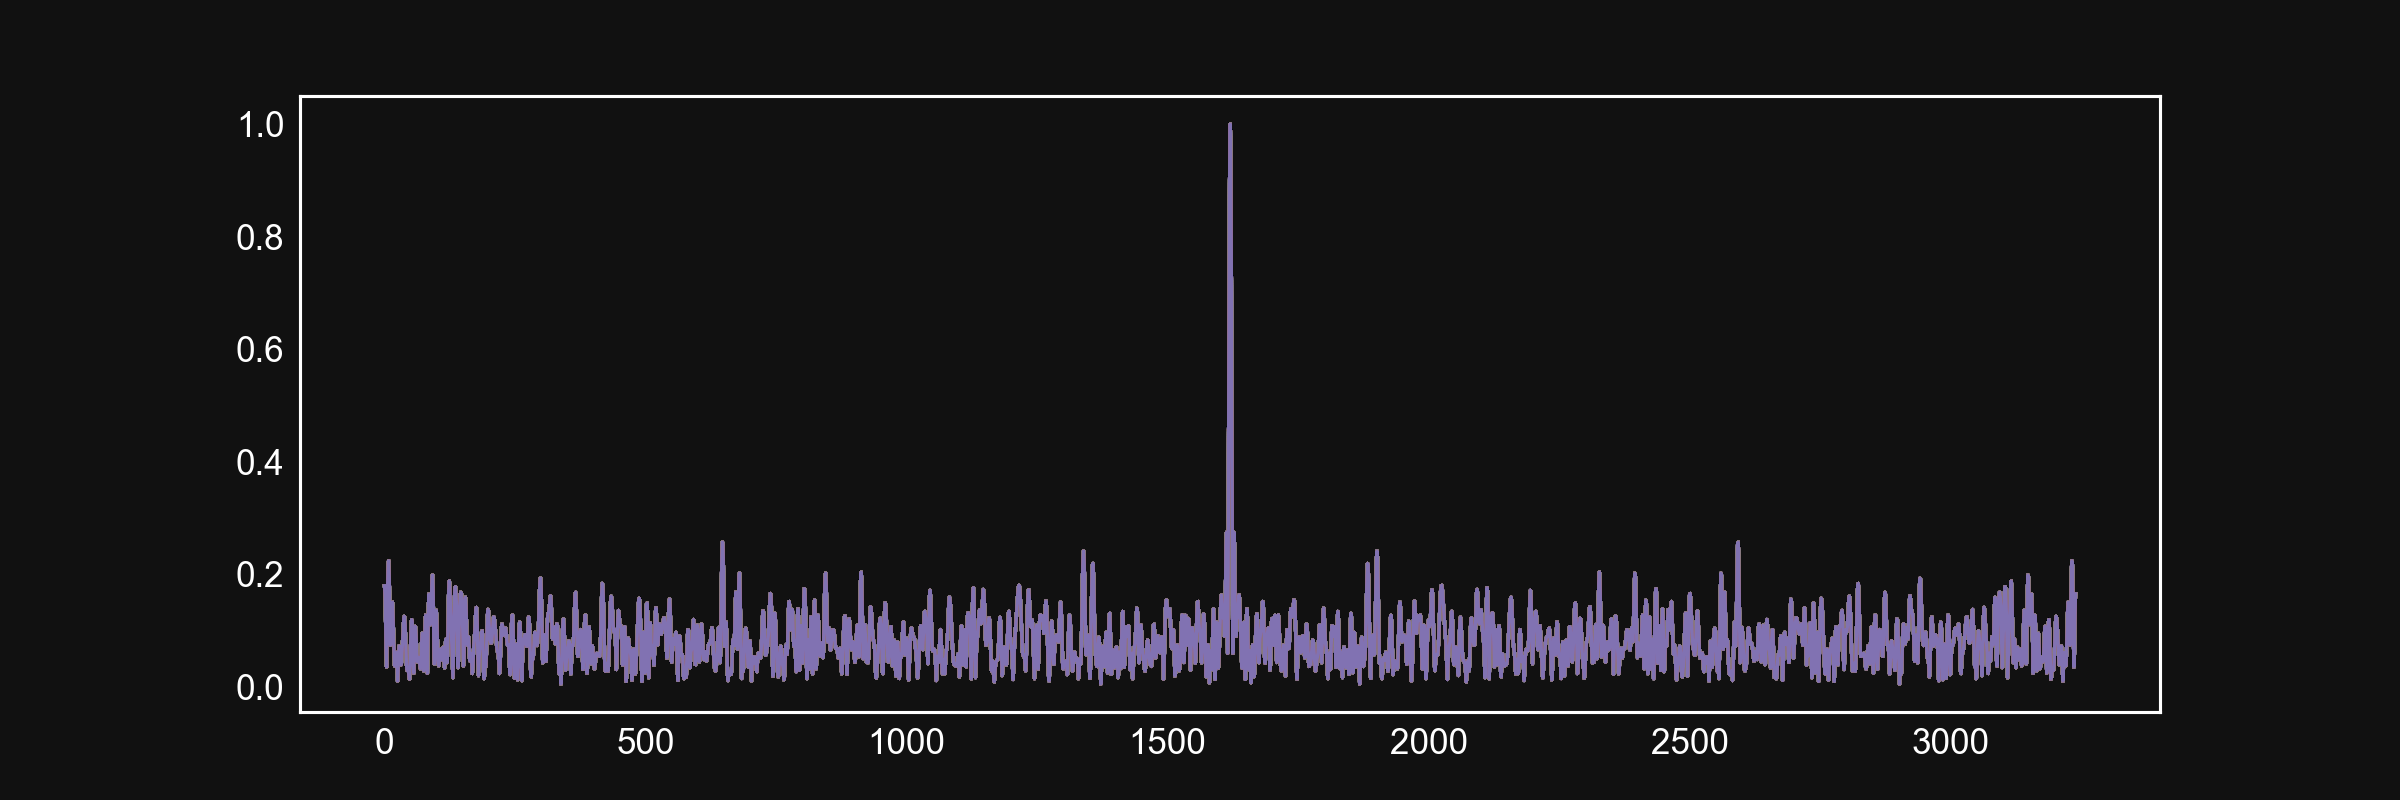

 ...]

In [6]:
plt.figure()
plt.plot(yp.crop_to_support(yp.abs(yp.Ft(recon.blur_kernel_list[0]))).T)

In [16]:
x = dataset.motiondeblur.blur_vectors()[0][0][0]

# Normalize
x = x / yp.scalar(yp.sum(x))

# Take fourier transform intensity
x_fft = yp.Ft(x)
sigma_x = yp.abs(x_fft) ** 2

# Calculate DNF
np.sqrt(1 / len(x) * np.sum(1 / sigma_x))

21.50883911576877

In [ ]:
# dataset.motiondeblur.position_segment_indicies = [0]
dataset.frame_mask = [10,11,12,13,14]

# Create recon object
recon = md.recon.Reconstruction(dataset, alpha_blend_distance=1000, normalize=False, estimate_background_poly=True)

# Perform reconstruction
recon.reconstruct(iteration_count=100, step_size=1, frame_number=4, mode='global', reg_types={'l1':1})

# Save result
recon.save(output_path, filename=recon.dataset.metadata.file_header + '_no_median', formats=['png', 'npz'], save_raw=True, downsample=4)

In [ ]:
plt.figure()
plt.imshow(recon.object_recovered)
plt.clim(0,100)

In [ ]:
recon.show()
plt.clim(0,300)

## Loop Over Segments

In [ ]:
for segment_index in dataset.motiondeblur.position_segment_indicies_full:
    # Set segment index
    dataset.motiondeblur.position_segment_indicies = [segment_index]
    
    # Create recon object
    recon = md.recon.Reconstruction(dataset, alpha_blend_distance=1000, pad_mode='mean', )

    # Perform reconstruction
#     recon.reconstruct(iteration_count=-1, step_size=1, frame_number=4, mode='global', reg_types={'l2': 1e-4})
    recon.reconstruct(iteration_count=100, step_size=1, frame_number=4, mode='global', reg_types={'l2': 1e-4})

    # Save result
    recon.save(output_path, filename=recon.dataset.metadata.file_header, formats=['png', 'npz'], save_raw=True, downsample=4)

In [ ]:
# Try with L1 Sparsity